# Hello BattMo  

---
* Time: run all first time: ~ 3.5 minutes
* Time: run second time: ~ 20 seconds
* Time: run and read step by step: ~ 30 minutes

---

Welcome to this hands-on tutorial where we’ll explore the basics of BattMo.jl — a powerful Julia package for simulating lithium-ion battery cells using physics-based models like the Doyle-Fuller-Newman (DFN) model. 

By the end of this tutorial, you’ll:

- Understand some basic features of BattMo.jl
- Run your first battery simulation
- Explore and visualize the output
- Learn how to tweak key parameters for custom behavior




Make sure you have selected your own environment at the right top of the notebook. If you have created it, but it doesn't show up as an option, try restarting VSCode and see if it appears. Let's import BattMo and some other packages into the kernel.

In [4]:
using BattMo, GLMakie, Jutul
GLMakie.activate!(inline=true)

## Part 1 - Run a simple simulation

Let's run a simple simulation first so we get an idea of the steps that it involves and then dive into each necessary step with more detail. The following script runs a simple constant current discharge simulation using default parameter sets and a built in plotting functionality. This first run can take some time as Julia compiles all functions and structs that it encounters. This compilation makes a second simulation very fast. Run the cell a second time to see the different in solving time.

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress   8%|████                                       |  ETA: 0:00:01

Progress  29%|█████████████                              |  ETA: 0:00:01

Progress  47%|█████████████████████                      |  ETA: 0:00:00

Progress  64%|████████████████████████████               |  ETA: 0:00:00

Progress  85%|█████████████████████████████████████      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32877 │       2.32877 │  340 (0) │
│ Linearization  │   3.32877 │       3.32877 │  486 (0) │
│ Linear solver  │   2.32877 │       2.32877 │  340 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.0679 │     3.80 % │  23.0914 │
│ Equations     │ 0.3173 │    25.39 % │ 154.2082 │
│ Assembly      │ 0.1346 │    10.77 % │  65.4259 │
│ Linear solve  │ 0.6340 │    35.50 % │ 215.5526 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

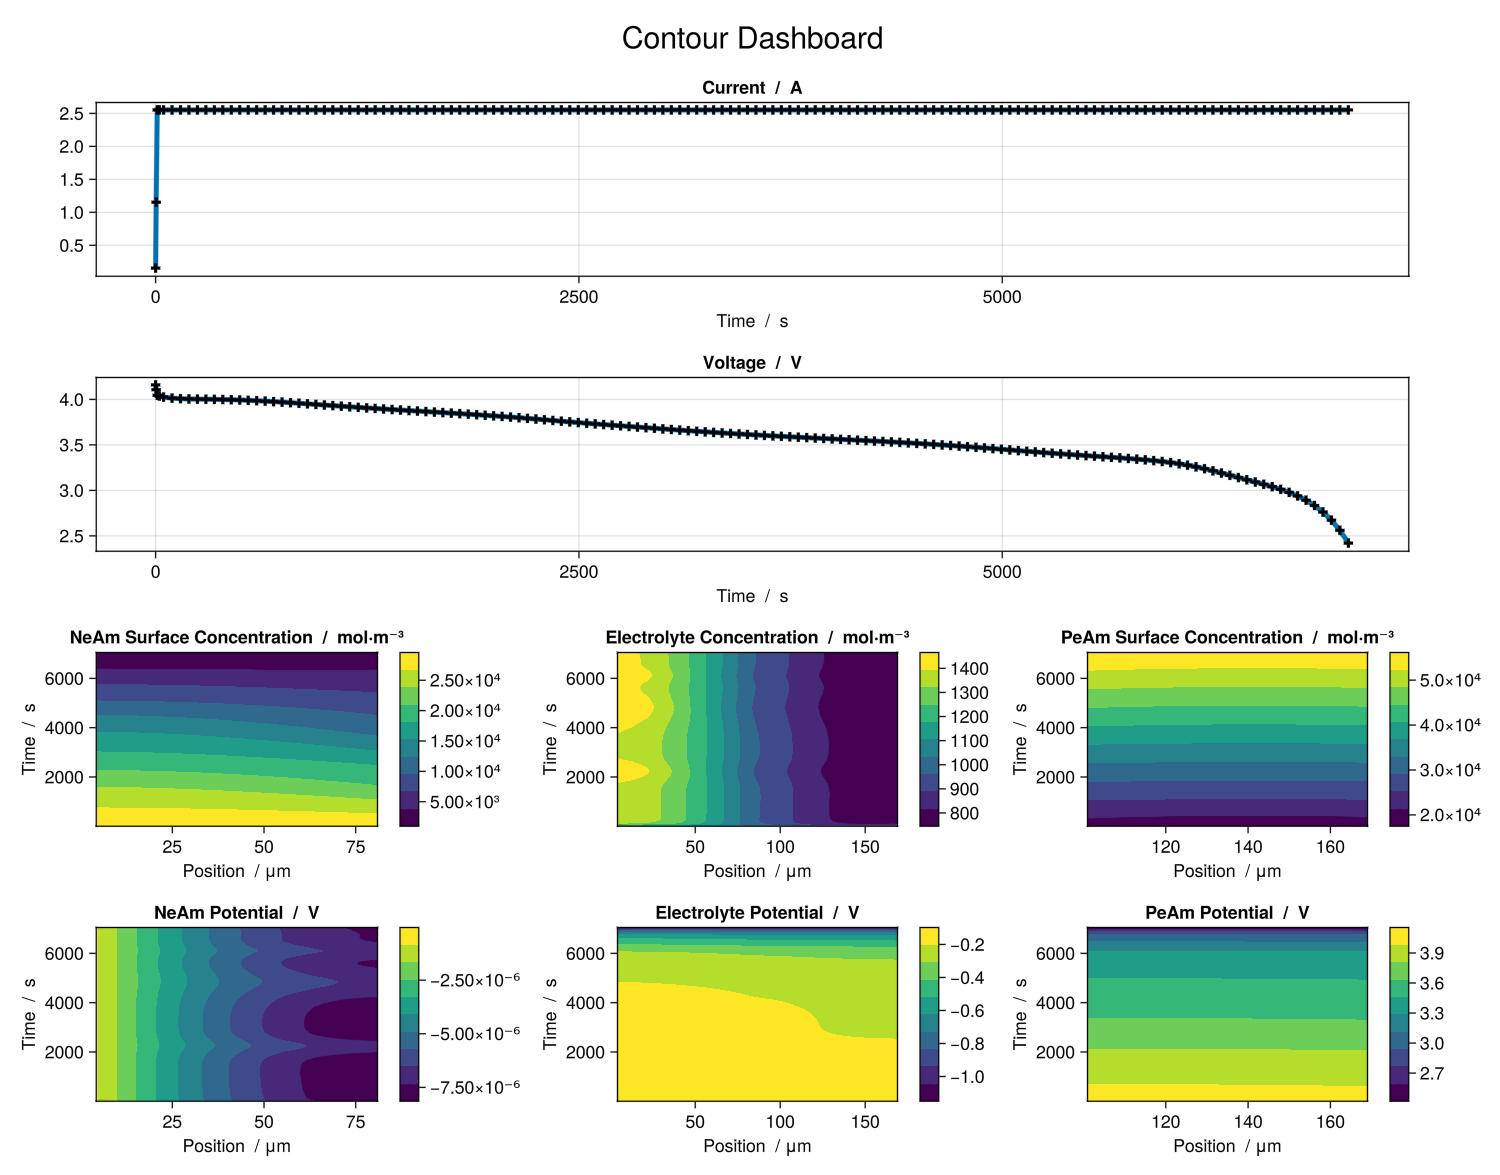

In [ ]:
import BattMo, GLMakie

# step 1: Load parameters
cell_parameters = load_cell_parameters(; from_default_set= "Chen2020")
cycling_protocol = load_cycling_protocol(; from_default_set= "CCDischarge")

# step 2: Instantiate a model setup
model_setup = LithiumIonBattery()

# step 3: Instantiate a Simulation object
sim = Simulation(model_setup, cell_parameters, cycling_protocol);

# step 4: Solve the simulation
output = solve(sim);

# step 5: Simple plotting
plot_dashboard(output; plot_type="contour")

Let's now dive deeper into each step!

#### Step 1 - Load parameters and settings

BattMo.jl structures its simulation inputs into two primary categories: Parameters and Settings. This distinction helps users differentiate between the physical characteristics of the battery system and the numerical configurations of the simulation.

**Parameters** represent the controllable variables in real-world experiments. They are further divided into:

- **Cell Parameters**: define the intrinsic properties of the battery cell, such as geometry and material characteristics.
- **Cycling Protocol Parameters**: specify how the cell is operated during a simulation.

**Settings** are used to configure numerical assumptions for solving equations and finding numerical solutions. They are further divided into:

- **Model Settings**: define numerical assumptions related to the battery model, such as diffusion methods or simplifications used in the simulation.
- **Simulation Settings**: define numerical assumptions specific to the simulation process, including time-stepping schemes and discretization precision:

**BattMo** stores cell parameters, cycling protocols and settings in a user-friendly JSON format to facilitate reuse. We can load the parameters directly from the default sets which can be very convenient for a quick parameter loading to test a simulation setup. In order to quickly see which default sets BattMo provides we can use the following function to print information about the sets available.

In [6]:
print_default_input_sets_info()


📋 Overview of Available Default Sets

📁 cell_parameters:         Chen2020, Xu2015
📁 cycling_protocols:       CCCV, CCCharge, CCCycling, CCDischarge, user_defined_current_function
📁 model_settings:          P2D, P4D_pouch
📁 simulation_settings:     P2D, P4D_pouch

📖 Detailed Descriptions

📂 cell_parameters
----------------------------------------------------------------------------------------------------
Chen2020
🔹 Cell name:       	LG INR 21700 M50
🔹 Cell case:       	Cylindrical
🔹 Source:          	[visit](https://doi.org/10.1149/1945-7111/ab9050)

🔹 Suitable for:
   • CurrentCollectors:  Generic
   • SEIModel:           Bolay
   • RampUp:             Sinusoidal
   • TransportInSolid:   FullDiffusion
   • ModelFramework:     P2D
🔹 Description:     	Parameter set of a cylindrical 21700 commercial cell (LGM50), for an electrochemical pseudo-two-dimensional (P2D) model, after calibration. SEI parameters are from Bolay2022: https://doi.org/10.1016/j.powera.2022.100083 .

Xu2015
🔹 Cell n

For our example, we load the cell parameter set from a NMC811 vs Graphite-SiOx cell whose parameters were determined in the [Chen 2020 paper](https://doi.org/10.1149/1945-7111/ab9050). We also load an example cycling protocol for a simple Constant Current Discharge. We can load them directly from the build in sets.

In [7]:
cell_parameters = load_cell_parameters(; from_default_set = "Chen2020");
cycling_protocol = load_cycling_protocol(; from_default_set = "CCDischarge");

This a quick way of testing a setup, but for the purpose of this workshop we would like to be able to see what a parameter set contains. Therefore, we'll retrieve the default parameter sets that BattMo provides and store them locally in a folder. We can do this by running the following script.

In [8]:
path = "."
folder_name = "default_sets"
generate_default_parameter_files(path, folder_name; force = true)

🛠 JSON files successfully written! Path:
	.\default_sets


".\\default_sets"

As we stored the default sets in our own folder, we can alter the default files if we want to and load the parameters from our dedicated folder.

In [9]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020.json");
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json");

#### Step 2 - Select a model setup

Next, we select the default Lithium-Ion Battery setup. A model can be thought as a mathematical implementation of the electrochemical and transport phenomena occuring in a real battery cell. The implementation consist of a system of partial differential equations and their corresponding parameters, constants and boundary conditions. The default Lithium-Ion Battery setup selected below contains the model settings to simulate a basic P2D model, where neither current collectors nor SEI growth are considered.

In [10]:
model_setup = LithiumIonBattery();

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


The LithiumIonBattery constructor validates the model settings on the back ground. If the model setup is valid we can continue and create a Simulation object by passing the model setup, cell parameters and a cycling protocol.

#### Step 3 - Initiate simulation object

 A Simulation can be thought as a procedure to predict how the cell responds to the cycling protocol by solving the equations in the model using the cell parameters passed. We first prepare the simulation.

In [11]:
sim = Simulation(model_setup, cell_parameters, cycling_protocol);

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────


The simulation object is only instantiated when the model setup is valid. We can see that the Simulation object also validates the parameters and settings on the back ground. Each parameter set is validated on whether they are sensible and complete. 

#### Step 4 - Solve simulation

When the Simulation object is valid we can solve the simulation by passing the object to the solve function. As Julia is a compiled language, the first time that we run a simulation it will take some time to compile the functions and structs that it encounters. This makes running a second simulation very fast. See the difference by running the script for a second time.

In [12]:
output = solve(sim);

Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress   1%|█                                          |  ETA: 0:17:09

Progress  16%|███████                                    |  ETA: 0:01:08

Progress  44%|███████████████████                        |  ETA: 0:00:17

Progress  76%|█████████████████████████████████          |  ETA: 0:00:04

Progress 100%|███████████████████████████████████████████| Time: 0:00:13


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32877 │       2.32877 │  340 (0) │
│ Linearization  │   3.32877 │       3.32877 │  486 (0) │
│ Linear solver  │   2.32877 │       2.32877 │  340 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬─────────┬────────────┬─────────╮
│ Timing type   │    Each │   Relative │   Total │
│               │      ms │ Percentage │       s │
├───────────────┼─────────┼────────────┼─────────┤
│ Properties    │  0.0942 │     0.25 % │  0.0320 │
│ Equations     │ 12.2397 │    45.65 % │  5.9485 │
│ Assembly      │  3.9560 │    14.76 % │  1.9226 │
│ Linear solve  │  0.6422 │     1.68 % │  0.2183 │
│ Linear setup  │  0.0000 │     0.00 % │  0.0000 │
│ Precond apply │  

#### Step 5 - Simple plotting

We can use some built in functions for quick plotting. The dashboard gives you a quick overview of some important ouput variables. You can choose to have interactive line plots where you can change the time step using a slider or contour plots that show the position and time in one plot.

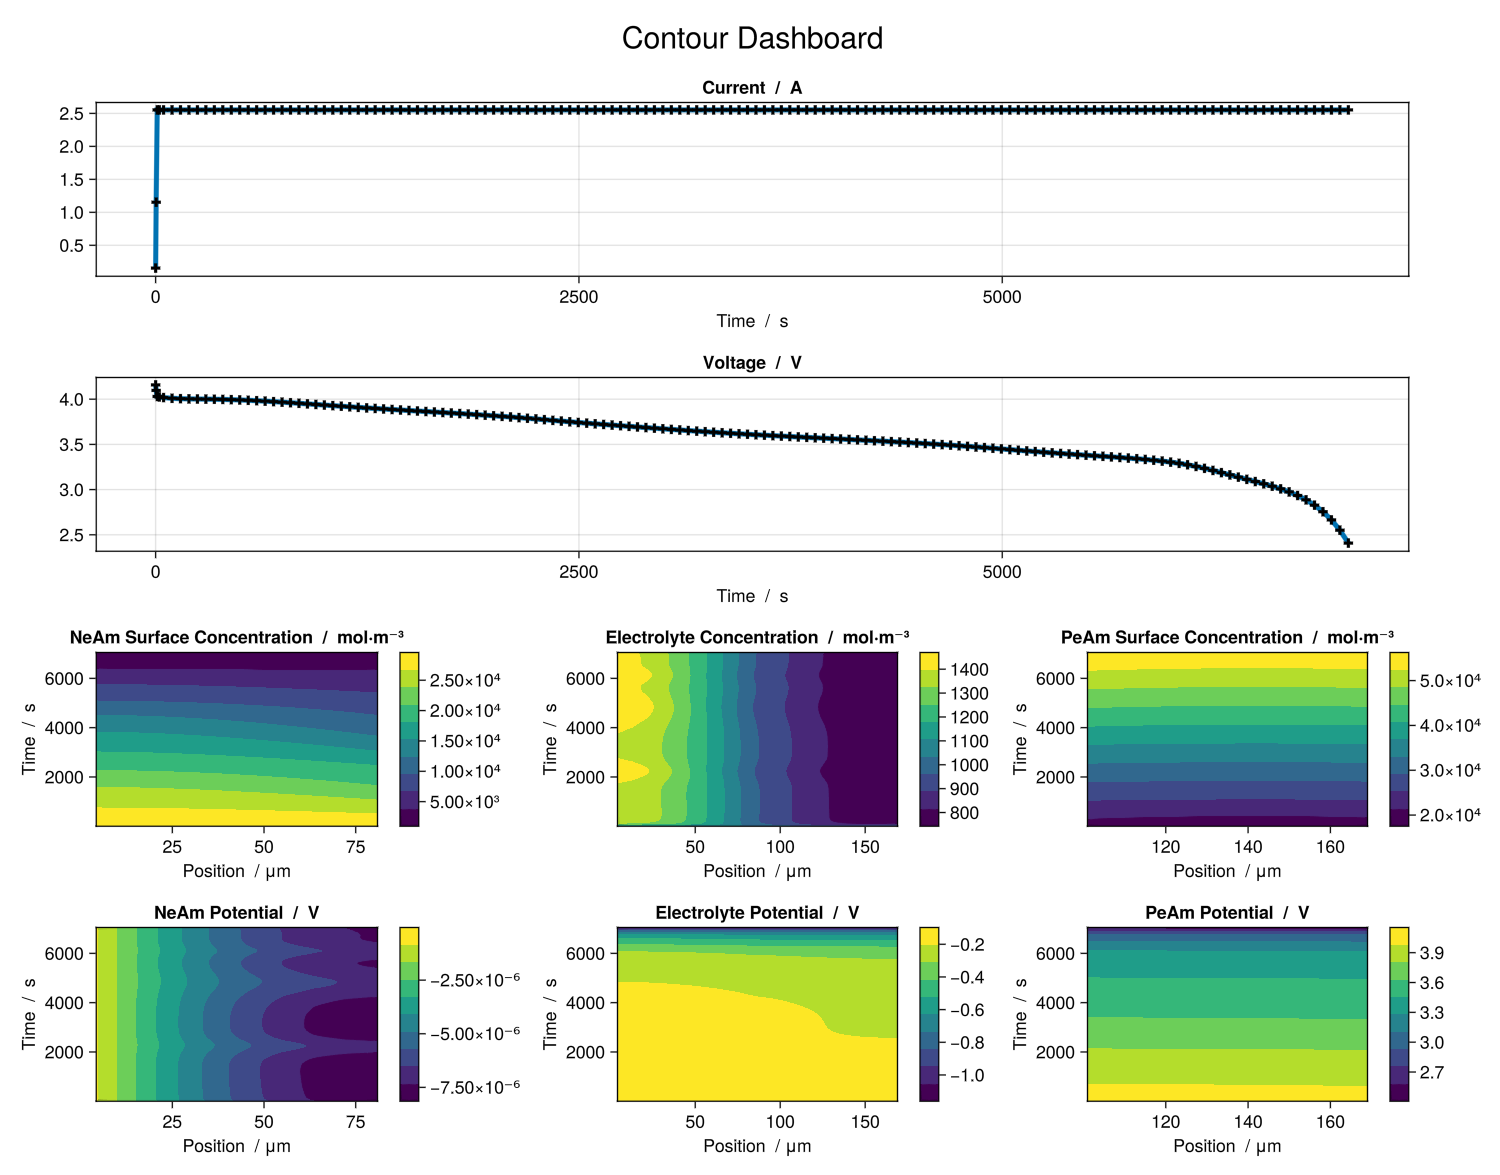

In [13]:
plot_dashboard(output; plot_type="contour")

As the line plot is an interactive plot and notebooks are not able to render interactive plots, we'll show it in a separate window. 

In [14]:
GLMakie.activate!(inline=false)

plot_dashboard(output; plot_type="line")

## Part 2 - Handle Cell Parameters

To change cell parameters, we can modify the JSON files directly, or we can read them into objects in the script and modify them as Dictionaries. A loaded cell parameter set is a Dictionary-like object which come with additional handy functions. First, lets list the outermost keys of the cell parameters object.

In [15]:
cell_parameters = load_cell_parameters(; from_default_set = "Chen2020")
keys(cell_parameters)

KeySet for a Dict{String, Any} with 6 entries. Keys:
  "Electrolyte"
  "Cell"
  "Metadata"
  "PositiveElectrode"
  "Separator"
  "NegativeElectrode"

Now we access the Separator key.

In [16]:
cell_parameters["Separator"]

Dict{String, Any} with 5 entries:
  "Description"          => "Ceramic-coated Polyolefin"
  "Density"              => 946
  "BruggemanCoefficient" => 1.5
  "Thickness"            => 1.2e-5
  "Porosity"             => 0.47

We have a flat list of parameters and values for the separator. In other cases, a key might nest other dictionaries, which can be accessed using the normal dictionary notation. Lets for instance see the active material parameters of the negative electrode.

In [17]:
cell_parameters["NegativeElectrode"]["ActiveMaterial"]

Dict{String, Any} with 16 entries:
  "ActivationEnergyOfDiffusion"       => 5000
  "NumberOfElectronsTransfered"       => 1
  "StoichiometricCoefficientAtSOC0"   => 0.0279
  "OpenCircuitPotential"              => "1.9793 * exp(-39.3631*(c/cmax)) + 0.2…
  "ReactionRateConstant"              => 6.716e-12
  "MassFraction"                      => 1.0
  "StoichiometricCoefficientAtSOC100" => 0.9014
  "ActivationEnergyOfReaction"        => 35000
  "MaximumConcentration"              => 33133.0
  "VolumetricSurfaceArea"             => 383959.0
  "Description"                       => "Graphite-SiOx"
  "DiffusionCoefficient"              => 3.3e-14
  "ParticleRadius"                    => 5.86e-6
  "Density"                           => 2260.0
  "ElectronicConductivity"            => 215
  "ChargeTransferCoefficient"         => 0.5

In addition to manipulating parameters as dictionaries, we provide additional handy attributes and functions. For instance, we can display all cell parameters:

In [18]:
cell_parameters

{
    "Electrolyte" =>     {
        "TransferenceNumber" => 0.2594
        "Description" => "1 mol/l LiPF6 with ethylene carbonate (EC): ethyl methyl carbonate (EMC) (3:7, V:V)"
        "DiffusionCoefficient" => "8.794*10^(-11)*(c/1000)^2 - 3.972*10^(-10)*(c/1000) + 4.862*10^(-10)"
        "IonicConductivity" => "0.1297*(c/1000)^3 - 2.51*(c/1000)^(1.5) + 3.329*(c/1000)"
        "Density" => 1200
        "ChargeNumber" => 1
        "Concentration" => 1000
    }
    "Cell" =>     {
        "NominalVoltage" => 3.71
        "ElectrodeGeometricSurfaceArea" => 0.1027
        "Height" => 0.065
        "NominalCapacity" => 4.8
        "Name" => "LG INR 21700 M50"
        "Case" => "Cylindrical"
        "OuterRadius" => 0.021
    }
    "Metadata" =>     {
        "Description" => "Parameter set of a cylindrical 21700 commercial cell (LGM50), for an electrochemical pseudo-two-dimensional (P2D) model, after calibration. SEI parameters are from Bolay2022: https://doi.org/10.1016/j.powera.2022.100

However, there are many parameters, nested into dictionaries. Often, we are more interested in a specific subset of parameters. We can find a parameter with the search_parameter function. For example, we'd like to now how electrode related objects and parameters are named:

In [19]:
search_parameter(cell_parameters, "Electrode")

1-element Vector{Any}:
 "[Cell][ElectrodeGeometricSurfaceArea] => 0.1027"

The search function also accepts partial matches and it is case-insentive.

In [20]:
search_parameter(cell_parameters, "char")

3-element Vector{Any}:
 "[NegativeElectrode][ActiveMaterial][ChargeTransferCoefficient] => 0.5"
 "[PositiveElectrode][ActiveMaterial][ChargeTransferCoefficient] => 0.5"
 "[Electrolyte][ChargeNumber] => 1"

Parameter that take single numerical values (e.g. real, integers, booleans) can be directly modified. Examples:

In [ ]:
cell_parameters["PositiveElectrode"]["ElectrodeCoating"]["Thickness"] = 8.2e-5

8.2e-5

Some parameters are described as functions or arrays, since the parameter value depends on other variables. For instance the Open Circuit Potentials of the Active Materials depend on the lithium stoichiometry and temperature. When we're unsure about the type or meaning of a parameter, we can print information on invidual parameters as well. For some parameters, that require more explanation, a link to the documentation is provided. Visit the documentation of the OpenCircuitPotential parameter to find more information on how to implement you own user defined functional parameters.

In [ ]:
parameter_name = "OpenCircuitPotential"

print_parameter_info(parameter_name)

ℹ️  Parameter Information
🔹 Name:         	OpenCircuitPotential
🔹 Description:		The open-circuit potential of the active material under a given intercalant stoichimetry and temperature.
🔹 Type:         	String, Dict{String, Vector}, Real
🔹 Unit:         	V
🔹 Documentation:	[visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/simulation_dependent_input)

🔹 Ontology link:	[visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_9c657fdc_b9d3_4964_907c_f9a6e8c5f52b)




## Part 3 - Handle Cycling protocols

The cycling protocol parameters can be altered in the same way as the cell parameters. Let's load a default CCCV cycling protocol.

In [ ]:
cycling_protocol = load_cycling_protocol(; from_file_path= "default_sets/cycling_protocols/CCCV.json")

{
    "Protocol" => "CCCV"
    "UpperVoltageLimit" => 4.0
    "InitialControl" => "charging"
    "DRate" => 1.0
    "TotalNumberOfCycles" => 3
    "CRate" => 1.0
    "InitialStateOfCharge" => 0
    "CurrentChangeLimit" => 0.0001
    "VoltageChangeLimit" => 0.0001
    "InitialTemperature" => 298.15
    "Metadata" =>     {
        "Description" => "Parameter set for a constant current constant voltage cyling protocol."
        "Title" => "CCCV"
    }
    "LowerVoltageLimit" => 3.0
}

In [ ]:
cycling_protocol["TotalNumberOfCycles"] = 10
cycling_protocol["CRate"] = 2.0

2.0

Let's run the CCCV protocol with the altered positive electrode coating thickness and plot some results

In [ ]:
model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol)

output = solve(sim);

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 1 day, 13.5 hours as 2700 report steps


Progress   0%|█                                          |  ETA: 0:03:13

Progress   1%|█                                          |  ETA: 0:00:26

Progress   2%|██                                         |  ETA: 0:00:17

Progress   4%|██                                         |  ETA: 0:00:13

Progress   7%|███                                        |  ETA: 0:00:09

Progress   9%|████                                       |  ETA: 0:00:12

Progress  10%|█████                                      |  ETA: 0:00:11

Progress  11%|█████                                      |  ETA: 0:00:12

Progress  13%|██████                                     |  ETA: 0:00:10

Progress  15%|███████                                    |  ETA: 0:00:13

Progress  16%|███████                                    |  ETA: 0:00:14

Progress  16%|████████                                   |  ETA: 0:00:14

Progress  18%|████████                                   |  ETA: 0:00:13

Progress  20%|█████████               

╭────────────────┬────────────┬────────────────┬─────────────╮
│ Iteration type │   Avg/step │   Avg/ministep │       Total │
│                │ 2153 steps │ 2331 ministeps │    (wasted) │
├────────────────┼────────────┼────────────────┼─────────────┤
│ Newton         │    2.89085 │         2.6701 │ 6224 (1845) │
│ Linearization  │    3.97353 │         3.6701 │ 8555 (1968) │
│ Linear solver  │    2.89085 │         2.6701 │ 6224 (1845) │
│ Precond apply  │        0.0 │            0.0 │       0 (0) │
╰────────────────┴────────────┴────────────────┴─────────────╯
╭───────────────┬────────┬────────────┬────────╮
│ Timing type   │   Each │   Relative │  Total │
│               │     ms │ Percentage │      s │
├───────────────┼────────┼────────────┼────────┤
│ Properties    │ 0.0602 │     4.37 % │ 0.3748 │
│ Equations     │ 0.2241 │    22.34 % │ 1.9176 │
│ Assembly      │ 0.0968 │     9.65 % │ 0.8284 │
│ Linear solve  │ 0.5938 │    43.06 % │ 3.6956 │
│ Linear setup  │ 0.0000 │     0.00 % │ 0

Let's use the simple dashboard plotting function to plot the voltage and current over time.

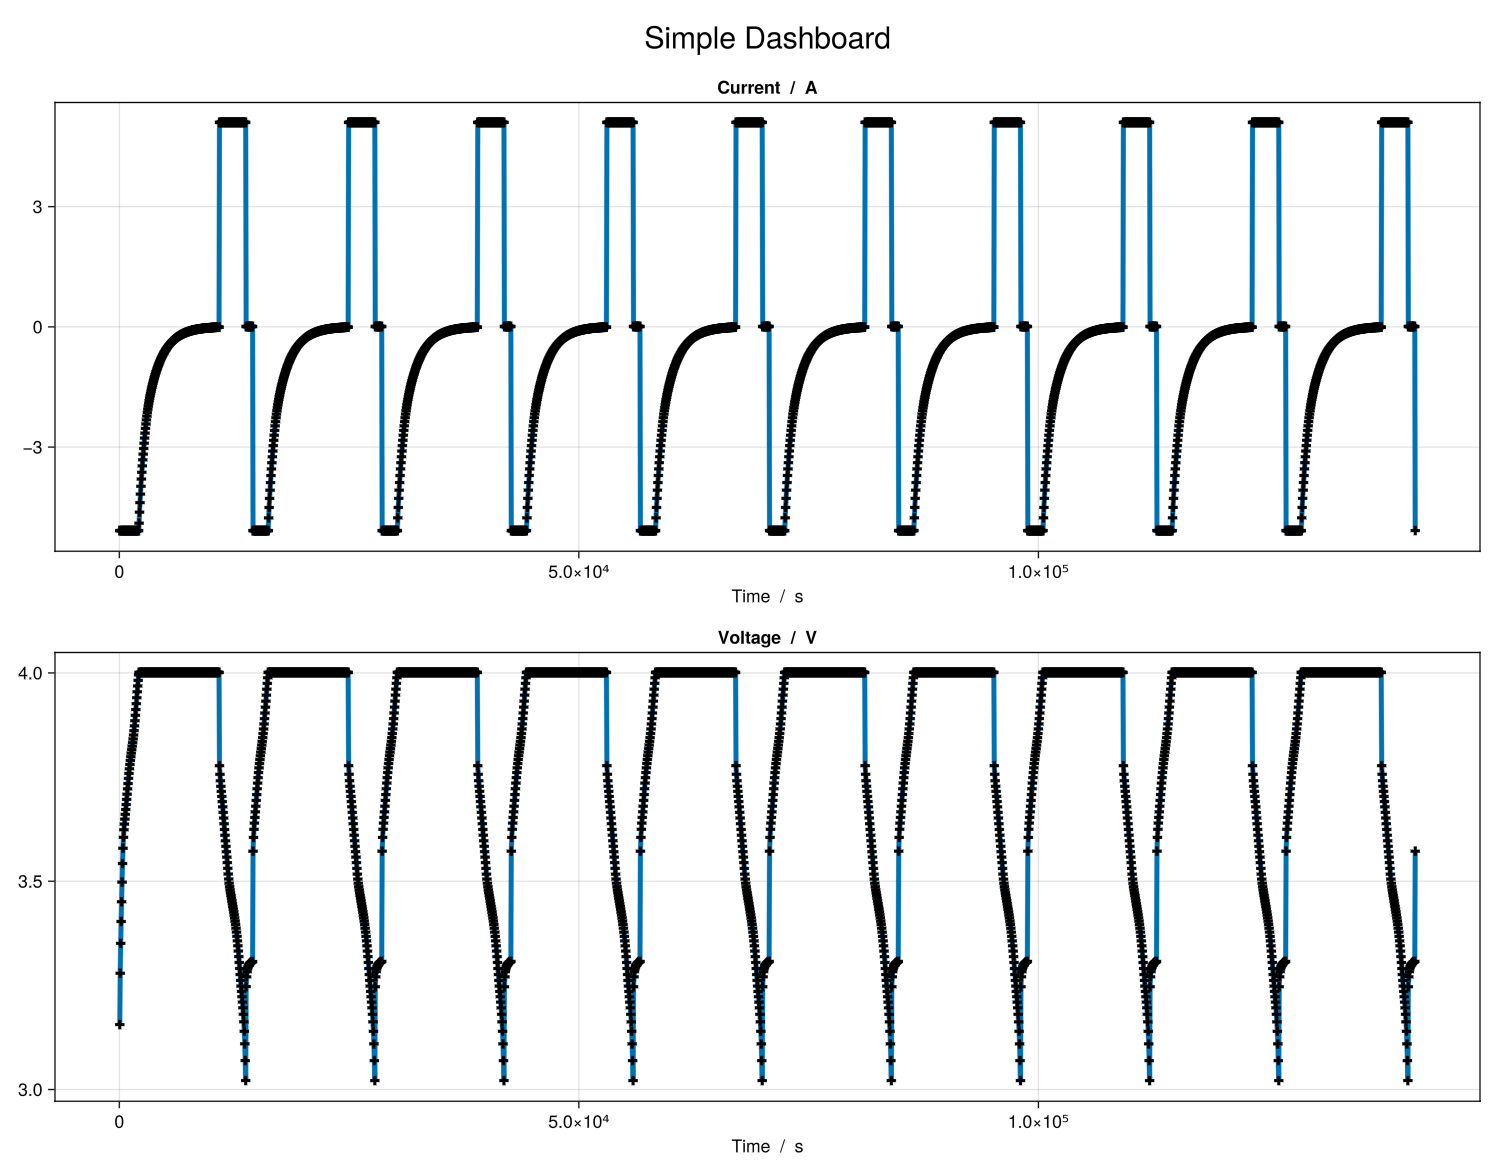

In [ ]:
GLMakie.activate!(inline=true)
plot_dashboard(output; plot_type = "simple")

## Part 4 - Retrieve output quantities and cell metrics

Let's use the output from the previous CCCV simulation. The output is a NamedTuple that contains a lot of different data and can sometimes be a bit difficult to navigate. Therefore BattMo provides some handy functions to retrieve the data that you want. First print an overview of the output to see which variables are available in the output.

In [ ]:
print_output_overview(output)


Case: TIME_SERIES
Variable                           Unit
--------------------------------------------------
Current                            A
Time                               s
Voltage                            V

Case: METRICS
Variable                           Unit
--------------------------------------------------
ChargeCapacity                     Ah
ChargeEnergy                       J
CycleNumber                        1
DischargeCapacity                  Ah
DischargeEnergy                    J
RoundTripEfficiency                %

Case: STATES
Variable                           Unit
--------------------------------------------------
ElectrolyteCharge                  C
ElectrolyteConcentration           mol·m⁻³
ElectrolyteConductivity            S·m⁻¹
ElectrolyteDiffusivity             m2·s
ElectrolyteMass                    g
ElectrolytePotential               V
NeAmCharge                         C
NeAmConcentration                  mol·L⁻¹
NeAmOpenCircuitPotential     

In the overview we can quickly see the aivalable variables and their units. We can also see that the variables have been devided into three categories: time series, states, and metrics. This has been done to provide some structure to the variables that is intuitive and cleans up the data. We also use these three categories when retrieving data. Let's first retrieve for example time series data like voltage, current and time.

In [ ]:
time_series = get_output_time_series(output)

t = time_series[:Time]
E = time_series[:Voltage]
I = time_series[:Current];

Let's now retrieve some state variables

In [ ]:
states = get_output_states(output)

negative_electrode_concentration = states[:NeAmConcentration]
negative_electrode_surface_concentration = states[:NeAmSurfaceConcentration];

We can also print more information on each individual variable. For example, it might be a bit unclear what the difference is between the NeAmConcenctration and NeAmSurfaceConcentration. For this purpose we can use the `print_output_variable_info()` function.

In [ ]:
print_output_variable_info("NeAmConcentration")

ℹ️  Variable Information
🔹 Name:         	NeAmConcentration
🔹 Description:		Radial distribution of lithium concentration in negative electrode particles.
🔹 Type:         	Vector{Real}
🔹 Shape:         	(nTime, nPosition, nNeAmRadius)
🔹 Unit:         	mol·L⁻¹



In [ ]:
print_output_variable_info("NeAmSurfaceConcentration")

ℹ️  Variable Information
🔹 Name:         	NeAmSurfaceConcentration
🔹 Description:		Concentration of lithium ions at the surface of negative electrode particles.
🔹 Type:         	Vector{Real}
🔹 Shape:         	(nTime, nPosition)
🔹 Unit:         	mol·L⁻¹



We can have a better idea of what the variable represents by reading the description and checking the shape of the variable. We can also retrieve some KPIs from the output.

In [ ]:
metrics = get_output_metrics(output)

discharge_capacity = metrics[:DischargeCapacity]
round_trip_efficiency = metrics[:RoundTripEfficiency]
cycle_numbers = metrics[:CycleNumber]

2820-element Vector{Int64}:
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  ⋮
  9
  9
  9
  9
  9
  9
  9
  9
 10

We can see that the last time step step contains cycle number 10 which represents the start of the 11th cycle, but as the simulation was ordered to complete 10 cycles, it terminates right after entering the 11th cycle. Therefore, we'll remove the data for cycle 10. Let's retrieve the unique cycle numbers in an array and plot the discharge capacity against it.

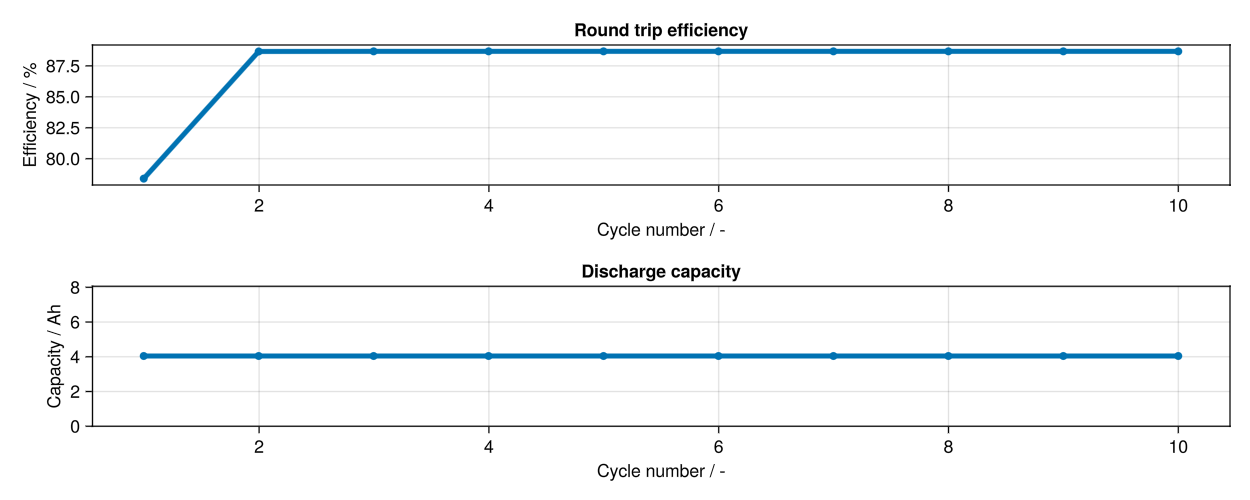

In [ ]:
unique_cycle_array = unique(cycle_numbers[1:end-1]) .+ 1 # Remove last cycle number, and shift so that the cycle numbers start from 1.

f = Figure(size = (1000, 400))

ax = Axis(f[1, 1], title = "Round trip efficiency", xlabel = "Cycle number / -", ylabel = "Efficiency / %",
)
scatterlines!(ax, unique_cycle_array, round_trip_efficiency[1:end-1]; linewidth = 4)

ax = Axis(f[2, 1], title = "Discharge capacity", xlabel = "Cycle number / -", ylabel = "Capacity / Ah",
)
scatterlines!(ax, unique_cycle_array, discharge_capacity[1:end-1]; linewidth = 4)

f

## Summary and overview

We learned how to run a simple simulation using default parameters and settings.

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  21%|██████████                                 |  ETA: 0:00:00

Progress  46%|████████████████████                       |  ETA: 0:00:00

Progress  68%|██████████████████████████████             |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32877 │       2.32877 │  340 (0) │
│ Linearization  │   3.32877 │       3.32877 │  486 (0) │
│ Linear solver  │   2.32877 │       2.32877 │  340 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.0578 │     4.05 % │  19.6422 │
│ Equations     │ 0.3658 │    36.70 % │ 177.7772 │
│ Assembly      │ 0.0926 │     9.29 % │  45.0016 │
│ Linear solve  │ 0.4081 │    28.64 % │ 138.7520 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

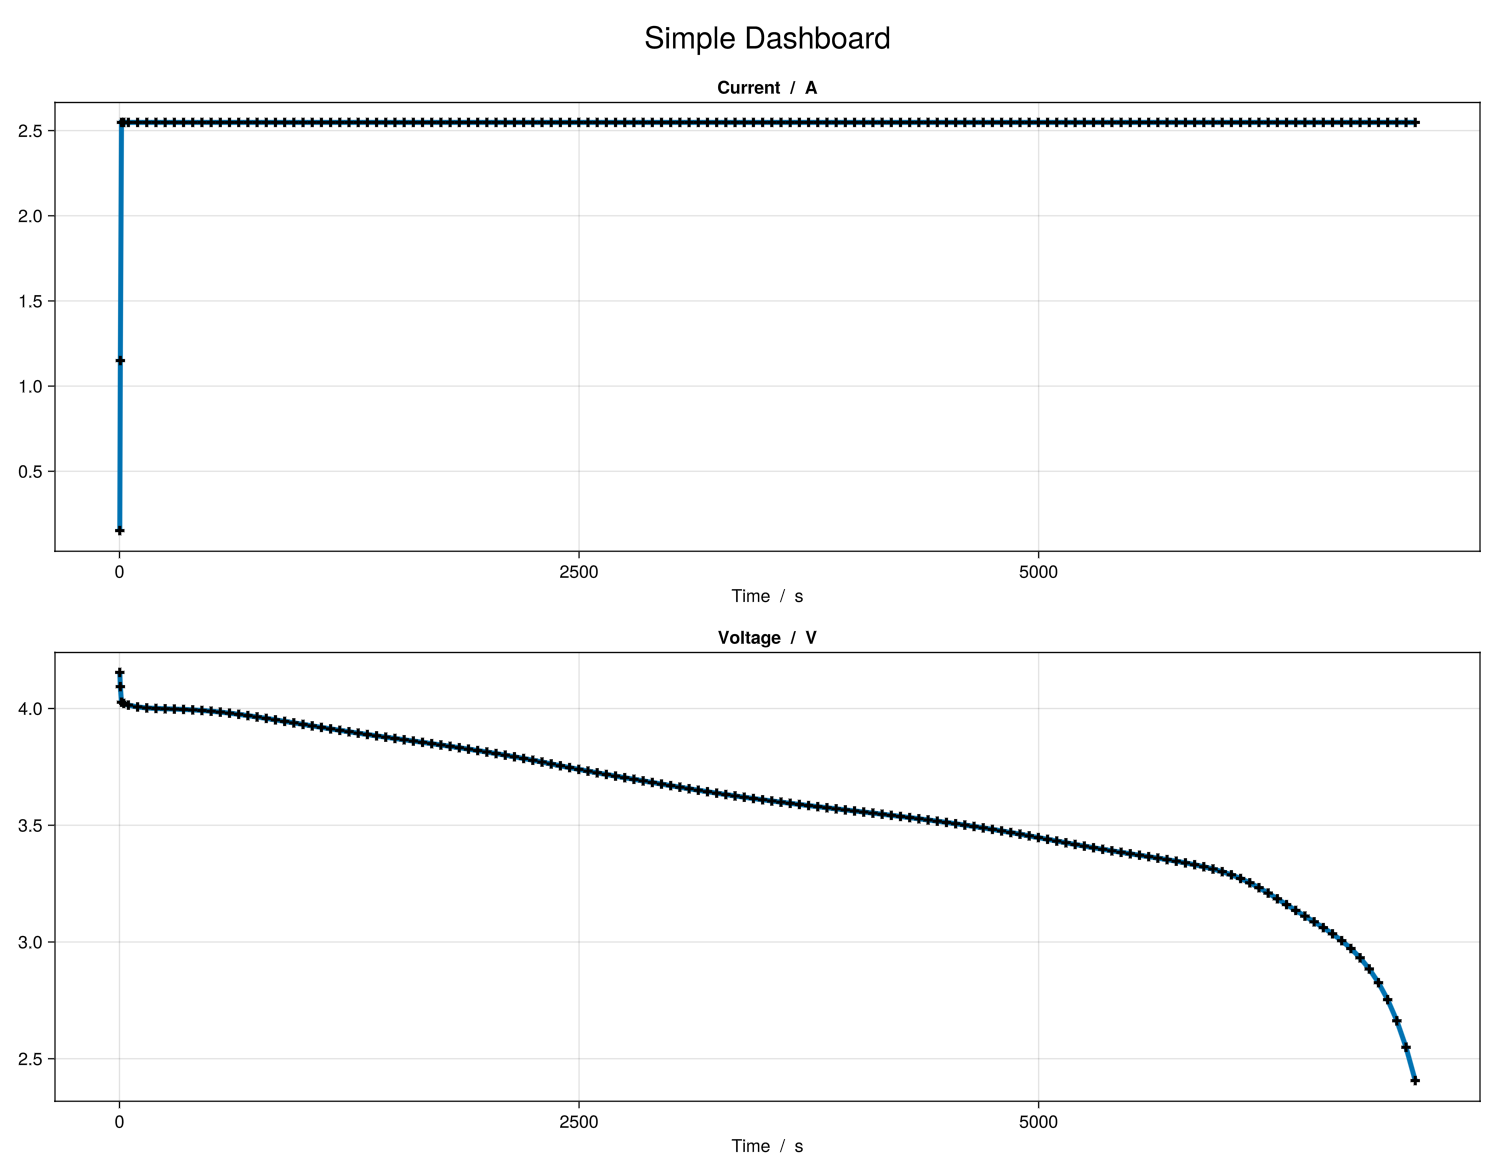

In [ ]:
using BattMo, GLMakie

cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020.json")
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json")

model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol);

output = solve(sim);

plot_dashboard(output)